In [1]:
import os

In [ ]:
/home/gridsan/groups/fastai/seesaw/user_study_data/sessions_mturk/


In [2]:
#session_ids = ['oscar_test']
search_paths = ['/home/gridsan/omoll/fastai_shared/omoll/user_study_sessions2/',
             #'./user_study_sessions_v3/'
               ]
#template = '/home2/gridsan/omoll/fastai_shared/omoll/user_study_sessionssessions2/session_oscar_test4/session_time_20220331-133413'

In [3]:
import importlib

In [4]:
# import seesaw
import seesaw.user_data_analysis
#importlib.reload(seesaw.user_data_analysis)
from seesaw.user_data_analysis import load_session_data
sessions_v3 = load_session_data(search_paths[0], use_ray=False)
#json.dump(sessions_v3, open('./sessions_v3.json', 'wb'))

  0%|          | 0/26 [00:00<?, ?it/s]

In [ ]:
# import ray
# ray.init('auto', ignore_reinit_error=True)

In [5]:
import hashlib
import random
import string

def get_user_hash(user):
    md = hashlib.md5(user.encode())
    user_hash = md.hexdigest()[:10]
    return user_hash

In [12]:
# pd.Timestamp(brit_start.timestamp(), unit='s')

In [8]:
real_users = [
    'ferdy',
    'jialin',
    'favyen',
    'ziniu',
    'xinjing',
    'kapil',
    'eugenie',
    'faraz',
    'brit',
    'test',#'brit' (between times 1649076970  1649084170)
    'markos',
    'harshal',
    'geoffrey',
    'siva',
]
import pytz

import datetime
brit_start = datetime.datetime(2022, 4, day=4, hour=8, minute=30, tzinfo=pytz.timezone('US/Eastern'))
brit_end = datetime.datetime(2022, 4, day=4, hour=9, minute=15, tzinfo=pytz.timezone('US/Eastern'))

users = real_users
import math

import datetime

base_modes = ['pytorch', 'default']
    
hash2uname = {get_user_hash(u):u for u in users}


In [9]:
import math

In [10]:
import datetime
import pytz

def process_ts(timestamp_s, timezone=pytz.timezone('US/Eastern')):
    """converts epoch (in seconds) to an easier to read datetime with timezone"""
    rounded_ts = round(timestamp_s, ndigits=3)
    ts = pd.to_datetime(rounded_ts, unit='s')
    tsloc = pytz.utc.localize(ts)
    ts_east = tsloc.astimezone(timezone)
    return ts_east

def process_action_log(log, seen_limit, accepted_limit):
    i = 0
    refine_total = 0.
    
    ret = {'start_time':None, 'log_cutoff_time':None, 
           'last_save_time':None, 'duration':None, 
           'shown':None, 'accepted':None,}
    
    while i < len(log) and log[i]['message'] != 'set_text':
        i+=1
    
    if i == len(log):
        return ret
    
    set_text = log[i]
    assert set_text['message'] == 'set_text'
    ret['start_time'] = process_ts(set_text['time'])
        
    while i < len(log) and log[i]['seen'] < seen_limit and log[i]['accepted'] < accepted_limit:
        i+=1
        
    if i == len(log):
        i -= 1
        
    last_record = log[i]
    ret['last_save_time'] = process_ts(log[-1]['time'])
    ret['seen_limit'] = seen_limit
    ret['accepted_limit'] = accepted_limit
    ret['log_cutoff_time'] = process_ts(last_record['time'])
    ret['shown'] = last_record['seen']
    ret['duration'] = (ret['log_cutoff_time'] - ret['start_time']).total_seconds()
    ret['accepted'] = last_record['accepted']
    return ret

In [11]:
excluded_session = [
    'pzldslyrpx', # a test session under brit's name
]

In [12]:
from seesaw.user_data_analysis import get_session_summary

In [13]:
def linear_gdata(sess, accepted_only=True):
    summary = get_session_summary(sess)
    session = sess['session']
    action_log = session['action_log']
    gdata = session['gdata']
        
    task_started = summary['task_started']
    ret = []
    ret.append([-1,-1, 0, 0, False])
    for i,l in enumerate(gdata):
        for j,r in enumerate(l):
            is_accepted = is_image_accepted(Imdata(**r))
            for time_rec in r['timing']:
                ret.append([i,j,time_rec['start_ms']/1000. - task_started, 
                            time_rec['end_ms']/1000. - task_started, is_accepted])
                break
            
    df = pd.DataFrame(ret, columns=['i', 'j', 'start_s', 'end_s', 'accepted'])
    df = df.sort_values(['start_s']).reset_index(drop=True)
    assert df.start_s.is_monotonic 
    df = df.assign(total_accepted=df.accepted.cumsum(), total_seen=np.arange(df.shape[0]))
    if accepted_only:
        df = df.groupby('total_accepted').apply(lambda x : x.head(n=1)).reset_index(drop=True)
    df = df.assign(**summary)
    return df

In [14]:
sessions = sessions_v3

In [15]:
get_session_summary(sessions[-1])

{'session_path': '/home/gridsan/omoll/fastai_shared/omoll/user_study_sessions2/session_yoecpsisqx/session_time_20220330-135006/',
 'init_time': 1648662523.0058155,
 'task_started': 1648662540.8889773,
 'last_time': Timestamp('2022-03-30 13:50:06.974999808-0400', tz='US/Eastern'),
 'mode': 'default',
 'dataset': 'objectnet',
 'qkey': 'gg',
 'user': 'f9af294304',
 'session_id': 'yoecpsisqx'}

In [16]:
linear_gdata

<function __main__.linear_gdata(sess, accepted_only=True)>

In [17]:
def fine_grained_accept_timeline(session, log_cutoff_time, start_time, max_accepted):
    """ extract table of (accepted, elapsed_time) pairs for each image"""
    
    gdata = session['gdata']
    image_pos = 0
    total_seen = 0
    total_accepted = 0
    grand_total_time = 0
    
    image_records = []
    elapsed_time = 0.
    for l in gdata:
        for r in l:
            for time_rec in r['timing']:
                if process_ts(time_rec['end_ms']/1000.) < log_cutoff_time:
                    elapsed_time = time_rec['end_ms']/1000. - start_time
                else:
                    pass
                
            if is_image_accepted(Imdata(**r)):
                total_accepted +=1
                image_records.append((total_accepted,elapsed_time))
                
    

In [18]:
def image_timing_summary(gdata, log_cutoff_time):
    """ extract table of (num_annotations, time) pairs for each image"""
    image_pos = 0
    total_seen = 0
    total_accepted = 0
    grand_total_time = 0
    
    image_records = []
    
    for l in gdata:
        for r in l:
            total_time_ms = 0.
            if 'timing' in r:
                for time_rec in r['timing']:
                    if process_ts(time_rec['end_ms']/1000.) < log_cutoff_time:
                        total_time_ms += time_rec['end_ms'] - time_rec['start_ms']
                    else:
                        pass
                        ## don't include times recorded after cuttoff
                image_records.append({'dbidx':r['dbidx'], 
                                      'accepted':is_image_accepted(Imdata(**r)),
                                      'total_time':total_time_ms
                                     })
                    
                if total_time_ms > 0:
                    total_seen +=1
                    if is_image_accepted(Imdata(**r)):
                        total_accepted +=1

                    grand_total_time += total_time_ms
            else: # ony one record is missing this
                total_seen +=1
                total_accepted += is_image_accepted(Imdata(**r))
                grand_total_time += np.nan
    
    summary = {'total_viewed':total_seen, 'total_client_accepted':total_accepted, 'total_viewing_time_s':grand_total_time/1000}
    return {'summary':summary, 'per_image':image_records}

def session_totals(sess, seen_limit = 75, accepted_limit=10, mode=None, clean_paths=None):
    
    if clean_paths:
        if sess['session_path'] not in clean_paths:
            return []
    
    mode in [None, 'image_timing', 'time_progress']
    sess_info = sess['session']
    params = sess_info['params']
    action_log = sess_info['action_log']
    
    sid = params.get('session_id')
    if sid is None or sid in excluded_session: # some sessions are excluded
        return [] 
    
    other_params = params['other_params']
    uname = hash2uname.get(params['other_params'].get('user'))
    
    if uname not in ['test', None]:
        pass
    elif (brit_start.timestamp() <= action_log[0]['time']  <= brit_end.timestamp()):
        uname = 'brit'
    else:
        return []
    
    if uname == 'siva':
        if other_params['qkey'] == 'cd':
            other_params['qkey'] = 'dg'
        elif other_params['qkey'] == 'dg':
            other_params['qkey'] = 'cd'
    
#     if params['other_params']['qkey']  in ['amb', 'pc']:
#         return []  
    #summary = process_action_log(action_log, seen_limit, accepted_limit)
    #total_shown = summary['shown']
    #image_timing = image_timing_summary(sess_info['gdata'], log_cutoff_time=summary['log_cutoff_time'])
    
#     time_progress = analyze_time_progress(sess_info['action_log'], 
#                                accept_target=accepted_limit, 
#                                seen_target=seen_limit, 
#                                start_time = summary['start_time'],
#                                log_cutoff_time=summary['log_cutoff_time'])
    
#     df = linear_gdata(sess)
#     df = df.assign(qkey=other_params['qkey'], uname=uname)
#     per_image = image_timing['per_image']
    df = linear_gdata(sess, accepted_only=False)
    df['qkey'] = other_params['qkey']
    df['uname'] = uname
    return [df]
        
    if mode == 'image_timing':
        for d in per_image:
            d['uname'] = uname
            d.update(**params['other_params'])
        return per_image
    elif mode == 'time_progress':
        for rec in time_progress:
            rec.update(**params['other_params'])
            rec['uname'] = uname
            rec['session_id'] = params['session_id']
            rec['last_save_time'] = summary['last_save_time']
        return time_progress
    else:
        return [{#'dataset':params['index_spec']['d_name'], 
                'session_path':sess['session_path'],
                'session_id':params['session_id'],
                'uname':uname,
                **params['other_params'],
                'query_string':sess_info['query_string'], 
                'total_requested':action_log[-1]['seen'], 
                'total_accepted':action_log[-1]['accepted'], 
#                 'linear_gdata':df,
            **summary,
            **image_timing['summary'],
                }]

In [19]:
def analyze_time_progress(exlog, accept_target, seen_target, start_time, log_cutoff_time):
#     updates = [rec for rec in exlog if rec['message'] in ['set_text', 'update_state.end']]
    first_recs = []
    accepted_so_far = -1
    seen_so_far = -1
    start_time = None
    for r in exlog:
        if start_time is None:
            if r['message'] != 'set_text':
                continue
            else:
                start_time = process_ts(r['time'])
            
        if r['accepted'] > accepted_so_far or seen_so_far >= seen_target:
            r = r.copy()
            r.update({'start_time':start_time})
            r['time'] = process_ts(r['time'])
            r['elapsed_time'] = (r['time'] - start_time).total_seconds()
            first_recs.append(r)
            accepted_so_far = r['accepted']
            seen_so_far = r['seen']
        
        if accepted_so_far >=accept_target or seen_so_far >= seen_target:
            break
            
    return first_recs

In [20]:
clean_session_paths = tot['session_path'].values.tolist()

NameError: name 'tot' is not defined

In [86]:
gdatas = sum(map(lambda x : session_totals(x, accepted_limit=target_accepted, clean_paths=clean_session_paths), sessions), start=[])

In [87]:
all_gdata = pd.concat(gdatas, ignore_index=True)

In [81]:
(2558 - 647)/647

2.953632148377125

In [89]:
all_gdata.groupby(['qkey','session_path'])[['total_accepted', 'total_seen']].max().sum()

total_accepted     647
total_seen        3376
dtype: int64

In [90]:
(3376  - 647)/647

4.217928902627512

In [21]:
all_gdata

NameError: name 'all_gdata' is not defined

In [28]:
target_accepted = 10
summaries = sum(map(lambda x : session_totals(x, accepted_limit=target_accepted), sessions), start=[])

tot = pd.DataFrame.from_records(summaries)
tot = tot.sort_values('start_time', ascending=True)
tot = tot.reset_index(drop=True)
# user_df =pd.DataFrame()
# tot = tot.merge(user_df, left_on='user', right_on='user', how='left')
tot = tot[tot.uname.isin(real_users) & ~tot.qkey.isin(['amb', 'pc']) & ~tot.uname.isin(['jialin'])]
tot = tot.groupby(['uname', 'session_id', 'start_time']).apply(lambda df : df.sort_values('last_save_time', ascending=False).head(n=1)).reset_index(drop=True)
tot = tot.assign(completed=tot.accepted >= target_accepted)

In [194]:
timing_summaries = sum(map(lambda x : session_totals(x, accepted_limit=10, mode='image_timing'), sessions), start=[])
image_timings = pd.DataFrame.from_records(timing_summaries)
image_timings = image_timings[(~image_timings.qkey.isin(['pc'])) & (~image_timings.uname.isin(['jialin'])) ]

In [26]:
time_prog = sum(map(lambda x : session_totals(x, accepted_limit=10, mode='time_progress'), sessions), start=[])


In [27]:
len(time_prog)

665

In [51]:
tpdf = time_prog_df[time_prog_df.elapsed_time <= 6*60]

In [56]:
tpdf.drop('last_time', axis=1).to_

,i,j,start_s,end_s,accepted,total_accepted,session_path,init_time,task_started,mode,dataset,qkey,user,session_id,uname,elapsed_time
0,-1,-1,0.000000,0.000000,0,0,./user_study_sessions_v3/session_xkcqdieqyd/se...,1.649194e+09,1.649194e+09,default,objectnet,gg,1955b38f13,xkcqdieqyd,siva,0.000000
1,0,0,0.114550,3.356550,1,1,./user_study_sessions_v3/session_xkcqdieqyd/se...,1.649194e+09,1.649194e+09,default,objectnet,gg,1955b38f13,xkcqdieqyd,siva,3.356550
2,0,1,3.358550,4.448550,2,2,./user_study_sessions_v3/session_xkcqdieqyd/se...,1.649194e+09,1.649194e+09,default,objectnet,gg,1955b38f13,xkcqdieqyd,siva,4.448550
3,0,2,4.457550,6.095550,3,3,./user_study_sessions_v3/session_xkcqdieqyd/se...,1.649194e+09,1.649194e+09,default,objectnet,gg,1955b38f13,xkcqdieqyd,siva,6.095550
4,1,0,6.100550,7.768550,4,4,./user_study_sessions_v3/session_xkcqdieqyd/se...,1.649194e+09,1.649194e+09,default,objectnet,gg,1955b38f13,xkcqdieqyd,siva,7.768550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,23,2,203.615043,207.598043,7,7,./user_study_sessions_v3/session_cklzthftqq/se...,1.649132e+09,1.649132e+09,pytorch,bdd,cd,363e3dac58,cklzthftqq,harshal,207.598043
711,25,0,214.705043,218.182043,8,8,./user_study_sessions_v3/session_cklzthftqq/se...,1.649132e+09,1.649132e+09,pytorch,bdd,cd,363e3dac58,cklzthftqq,harshal,218.182043
712,25,1,218.187043,221.084043,9,9,./user_study_sessions_v3/session_cklzthftqq/se...,1.649132e+09,1.649132e+09,pytorch,bdd,cd,363e3dac58,cklzthftqq,harshal,221.084043
713,25,2,221.088043,230.444043,10,10,./user_study_sessions_v3/session_cklzthftqq/se...,1.649132e+09,1.649132e+09,pytorch,bdd,cd,363e3dac58,cklzthftqq,harshal,230.444043


In [57]:
tpdf.drop('last_time', axis=1).to_parquet('time_view_v3.parquet')

In [45]:
time_prog_df = all_gdata.assign(elapsed_time=all_gdata['end_s'], accepted=all_gdata['total_accepted'])
time_prog_df = time_prog_df[~time_prog_df.uname.isin(['jialin'])]


plot_time_prog_data = time_prog_df.groupby(['qkey', 'mode','accepted']).elapsed_time.apply(bootstrap_stat).reset_index()
plot_time_prog_data = plot_time_prog_data.assign(grp=plot_time_prog_data[['mode', 'accepted']].apply(tuple,axis=1))

In [42]:
#plot_time_prog_data = plot_time_prog_data[plot_time_prog_data['n'] > 1]

In [46]:
plot_time_prog_data

,qkey,mode,accepted,level_3,lower,med,mean,high,confidence_level,n,grp
0,cd,default,0,0,0.000000,0.000000,0.000000,0.000000,0.95,7,"(default, 0)"
1,cd,default,1,0,33.602886,40.192141,63.000670,121.603807,0.95,7,"(default, 1)"
2,cd,default,2,0,39.646072,73.663886,94.731434,155.360352,0.95,5,"(default, 2)"
3,cd,default,3,0,150.931717,153.865886,160.902892,177.911072,0.95,3,"(default, 3)"
4,cd,default,4,0,202.186072,210.344979,210.344979,218.503886,0.95,2,"(default, 4)"
...,...,...,...,...,...,...,...,...,...,...,...
180,wch,pytorch,8,0,63.450259,102.667838,94.862323,118.468871,0.95,6,"(pytorch, 8)"
181,wch,pytorch,9,0,70.328759,114.561921,103.747489,126.351788,0.95,6,"(pytorch, 9)"
182,wch,pytorch,10,0,80.900259,119.439421,113.124823,139.034788,0.95,6,"(pytorch, 10)"
183,wch,pytorch,11,0,127.443317,136.090338,136.090338,144.737358,0.95,2,"(pytorch, 11)"


In [169]:
# plot_time_prog_data = plot_time_prog_data.assign(confidence_interval_start=plot_time_prog_data['mean'] - 2*plot_time_prog_data['sem'],
#                            confidence_interval_end=plot_time_prog_data['mean'] + 2*plot_time_prog_data['sem'])

/nvme_drive/orm/seesaw/.seesaw_env/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


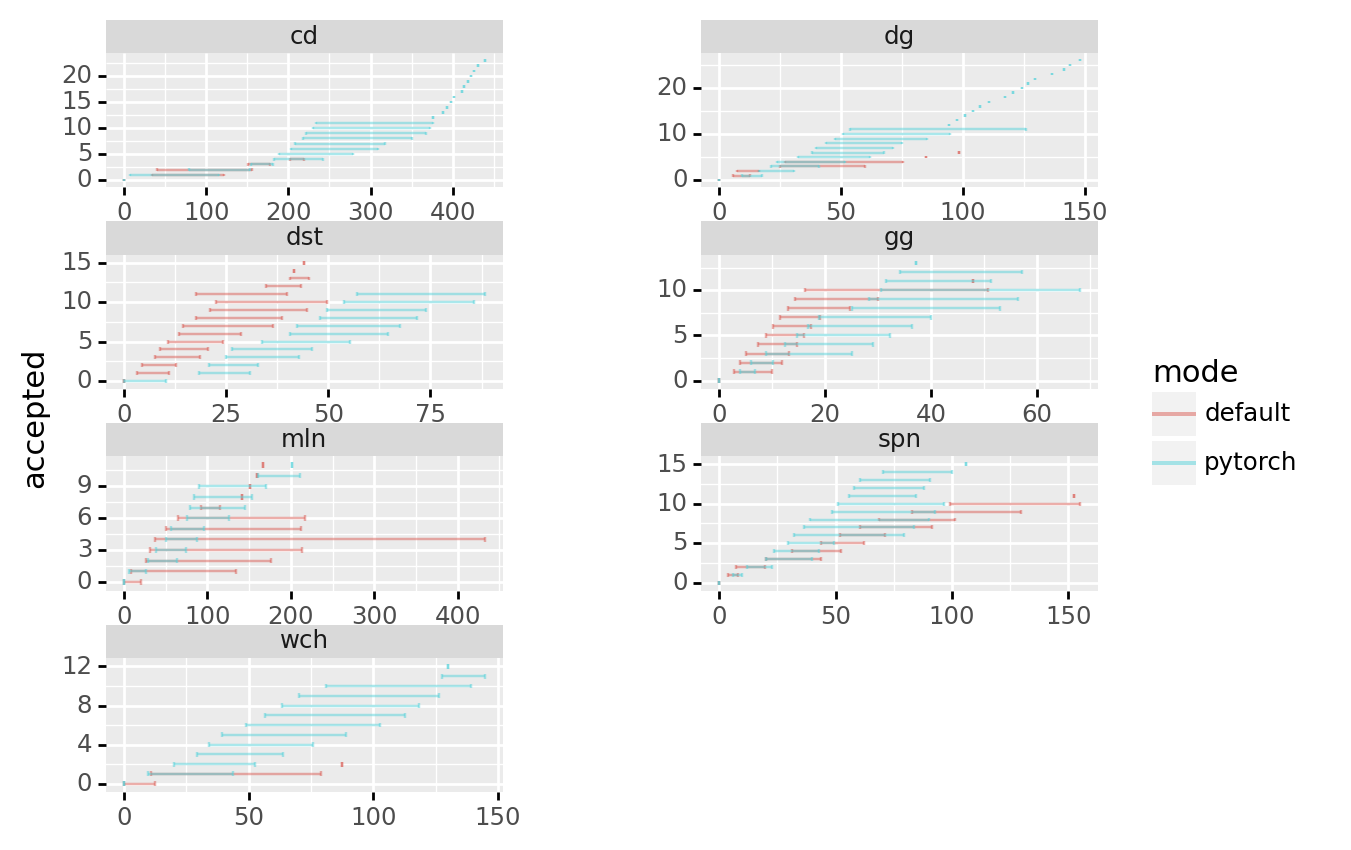

<ggplot: (8757077639421)>

In [49]:
( ggplot(plot_time_prog_data) + 
     geom_errorbar(aes(x='accepted', ymin='lower', ymax='high', 
                       group='grp', color='mode'), alpha=.5, position='identity') +
     facet_wrap(['qkey'], ncol=2, scales='free') +
     coord_flip() +
     theme(subplots_adjust={'hspace':.5, 'wspace':.5},)
)

In [48]:
from plotnine import *

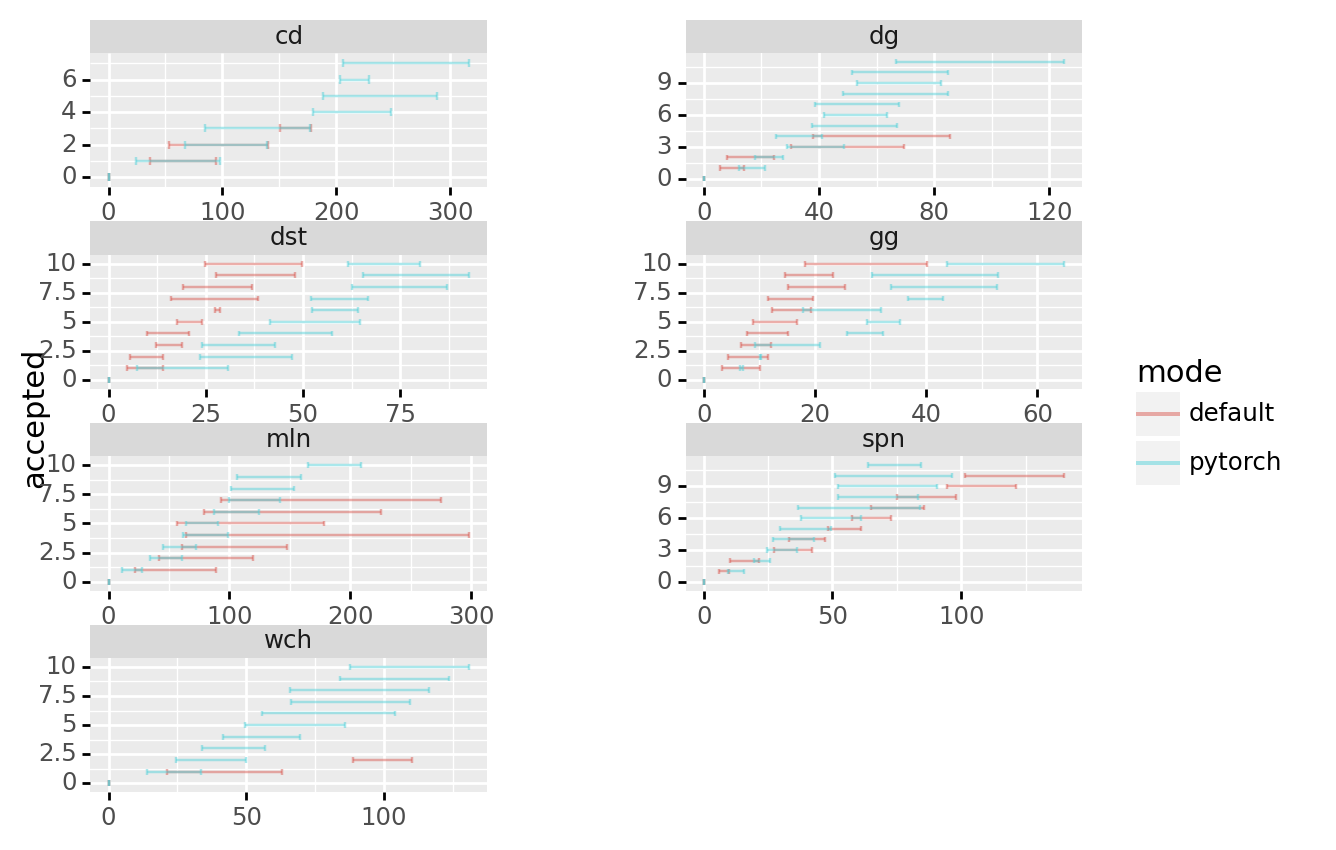

<ggplot: (8789012987197)>

In [174]:
( ggplot(plot_time_prog_data) + 
     geom_errorbar(aes(x='accepted', ymin='lower', ymax='high', 
                       group='grp', color='mode'), alpha=.5, position='identity') +
     facet_wrap(['qkey'], ncol=2, scales='free') +
     coord_flip() +
     theme(subplots_adjust={'hspace':.5, 'wspace':.5},)
)

In [21]:
image_timings.groupby(['qkey','mode']).agg({'total_time':('median', 'sem')}).unstack(level=-1)

total_time                                
         median                 sem            
mode    default pytorch     default     pytorch
qkey                                           
cd       1580.0  1724.0   64.133368  135.816760
dg       1439.0  3529.0  106.997219  355.791306
dst      1289.0  1900.0  195.670633  170.938567
gg       1278.0  2678.0  197.243020  330.523248
mln      1453.0  2257.0   88.308624  227.728612
spn      1454.0  2819.0  117.766364  742.210789
wch      1302.0  2539.5   78.467489  178.334485

In [66]:
time_data = [[1979.488804, 2410.213389, 49.584381, 84.952874, ],
[3003.378917, 4411.515837, 140.369595, 225.083612]]

In [69]:
df = pd.DataFrame(time_data, columns=['baseline', 'seesaw', 'baseline_se', 'seesaw_se'], index=['marked_relevant', 'non_marked'])

In [73]:
print(df.to_latex(float_format='{:.0f}'.format))

\begin{tabular}{lrrrr}
\toprule
{} &  baseline &  seesaw &  baseline\_se &  seesaw\_se \\
\midrule
marked\_relevant &      1979 &    2410 &           50 &         85 \\
non\_marked      &      3003 &    4412 &          140 &        225 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2588075/2543497918.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [22]:
image_timings.groupby(['accepted','mode']).agg({'total_time':('mean', 'sem')}).unstack(level=-1)

total_time                                     
                 mean                      sem            
mode          default      pytorch     default     pytorch
accepted                                                  
False     1979.488804  2410.213389   49.584381   84.952874
True      3003.378917  4411.515837  140.369595  225.083612

In [23]:
#min_times = tot.groupby(['qkey']).agg({'duration':('min', 'mean','std', 'size')})
# time_cutoffs = {}
# for r in min_times.itertuples():
#     time_cutoffs[r.Index] = r._1


In [25]:
# summary = tot.groupby(['dataset','qkey', 'mode']).agg({'total_viewing_time_s':('mean', 'std', 'size')}).unstack(level=-1)
# summary.columns = summary.columns.droplevel(0)

In [26]:
# summary

In [27]:
# goals of study: 
## 1. give some absolute times it takes to complete a task, show it varies (diff strings, diff feedback)

## 2. compare how the baseline does:
  ### 1.1 how many tasks were completed one mode vs other. 
    ## 1.2 in tasks that were completed, how did times look?

## 2. show the time it takes to process a single image in one mode vs the other. 
 # ( how large a burden does localized labeling impose?)
  ## similar time 2.1 sec when images are negative. difference is about .3 sec.
  ##  time of 4 vs 3 sec when providing box feedback.  
    
## 3. show more interesting queries on BDD dataset which are more difficult than existing queries.
## 4. server latency vs user thinking time.

In [28]:
query_totals = tot.groupby(['qkey', 'mode']).size().unstack(level=-1)
query_totals

mode,default,pytorch
qkey,,
cd,7,6
dg,6,7
dst,6,7
gg,7,6
mln,7,6
spn,6,7
wch,7,6


In [29]:
ct =  tot[tot.completed].groupby(['qkey', 'mode']).size().unstack(level=-1)
completed_totals = ct.reindex(query_totals.index).fillna(0).astype('int')
completed_totals

mode,default,pytorch
qkey,,
cd,0,0
dg,0,7
dst,6,7
gg,7,6
mln,1,6
spn,5,7
wch,0,6


In [30]:
(completed_totals/query_totals).round(2)

mode,default,pytorch
qkey,,
cd,0.00,0.0
dg,0.00,1.0
dst,1.00,1.0
gg,1.00,1.0
mln,0.14,1.0
spn,0.83,1.0
wch,0.00,1.0


In [31]:
task_completed =  tot[tot.completed]

In [32]:
tot.groupby(['dataset','qkey', 'mode']).agg({'accepted':('mean', 'sem', 'size')}).unstack(level=-1)

accepted                                               
                     mean                  sem              size        
mode              default    pytorch   default   pytorch default pytorch
dataset   qkey                                                          
bdd       cd     1.857143   3.833333  0.260820  1.301708       7       6
          dg     4.333333  10.571429  0.333333  0.297381       6       7
          wch    1.285714  10.166667  0.184428  0.166667       7       6
coco      mln    6.000000  10.000000  0.925820  0.000000       7       6
          spn   10.000000  10.428571  0.258199  0.202031       6       7
objectnet dst   10.333333  10.142857  0.333333  0.142857       6       7
          gg    10.428571  10.333333  0.297381  0.333333       7       6

In [88]:
comparable_cases = (completed_totals == totals).all(axis=1)

In [38]:
# option 2: show results after a fixed time. change this fixed time for all queries.

In [60]:
# car door analysis: what if neither method gets 10? # how many did we find using the different methods? (we didn't reach 10, so both stop at 75)
# wheelchair: what if one method reaches 10 but the other one does not?

In [231]:
#host = 'ec2-34-235-127-81.compute-1.amazonaws.com'
host = 'ec2-54-227-213-119.compute-1.amazonaws.com'
port = '9000'

url_template = (f"http://{host}:{port}/user_session?" +
        "mode={mode}&dataset={dataset}&qkey={qkey}&session_id={session_id}&user={user}")

In [41]:
# coco sugar cane: the first one is correct. the second one is mislabelled in the ground truth. 
# bdd train: for some reason did not work that well when I did it. (took about 100 to find the first 10), 
            # whereas when I used the plain one I seemed to get better results earlier (but did not get to 100.)

        
# objectnet dustpan: I used dustpan and all top 11 results were ok. dust pan is the one used in the benchmark.
# objectnet egg carton: seems to work well. 
    # would be nice to mark image from outside.
    # would be good if keyboard controls remain valid even if box is selected (for plain mode)
    
# coco spoon: seems to work well.
# coco melon: works well. we should double check what type of negative feedback is happening right now.

# bdd dog: a picture of a dog (multi: quite terrible for some reason if we use 'a picture of a dog'. a dog is ok however)
# bdd open car door: plain finds 1 after about 80 images. still only one after 110.
           # seesaw finds 1 after about 60. then 7 by 110.


In [42]:
# brit was user test ....

In [262]:
user = users[-1]
#user = 'manny_test'
print('user', user)
dq = {
    'bdd':{'pc':'police car', 'amb':'ambulance', 'dg':'dog', 'cd':'open car door', 'wch':'wheelchair'},
    'coco':{'mln':'melon', 'spn':'spoon'},
    'objectnet':{'dst':'dustpan', 'gg':'egg carton'},
}

user siva


In [171]:
import string
import random

In [169]:
string.ascii_letters

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [233]:
#/home/gridsan/groups/fastai/seesaw/data/coco/train2017/000000411517.jpg

In [264]:
# siva : dg => open door, open door => dg

In [263]:
user_hash = get_user_hash(user)
# md = hashlib.md5(user.encode())
# user_hash = md.hexdigest()[:10]

modes_a = [1, 1, 0]
mode_offset = 0

link_no = 1
for di,(dataset,qnames) in enumerate(dq.items()):
    mode_n = (modes_a[di] + mode_offset) % 2
    for i,q in enumerate(qnames.keys()):
        #print(f'{link_no}) (dataset {dataset}, qkey {q}): {qnames[q]}')
        session_id = ''.join([random.choice(string.ascii_lowercase) for i in range(10)])
        mode = base_modes[(i + mode_n) % 2]
        url = url_template.format(mode=mode, user=user_hash, session_id=session_id, qkey=q, dataset=dataset)
        print(f'{link_no})', url)
        link_no +=1

1) http://ec2-54-227-213-119.compute-1.amazonaws.com:9000/user_session?mode=default&dataset=bdd&qkey=pc&session_id=naepxzsntv&user=1955b38f13
2) http://ec2-54-227-213-119.compute-1.amazonaws.com:9000/user_session?mode=pytorch&dataset=bdd&qkey=amb&session_id=lgdtmihsps&user=1955b38f13
3) http://ec2-54-227-213-119.compute-1.amazonaws.com:9000/user_session?mode=default&dataset=bdd&qkey=dg&session_id=ncdrurgezp&user=1955b38f13
4) http://ec2-54-227-213-119.compute-1.amazonaws.com:9000/user_session?mode=pytorch&dataset=bdd&qkey=cd&session_id=lotdebfwtn&user=1955b38f13
5) http://ec2-54-227-213-119.compute-1.amazonaws.com:9000/user_session?mode=default&dataset=bdd&qkey=wch&session_id=aiduizsilt&user=1955b38f13
6) http://ec2-54-227-213-119.compute-1.amazonaws.com:9000/user_session?mode=default&dataset=coco&qkey=mln&session_id=jzlupilnzx&user=1955b38f13
7) http://ec2-54-227-213-119.compute-1.amazonaws.com:9000/user_session?mode=pytorch&dataset=coco&qkey=spn&session_id=atyhgdwzhw&user=1955b38f13


In [108]:
analyze_sess(sess_info)

{'dataset': 'coco',
 'session_id': 'oscar_test2',
 'mode': 'default',
 'qkey': 'spoon',
 'user': 'oscar',
 'query_string': 'a spoon',
 'total_time': 97.68128228187561,
 'total_seen': 30,
 'total_accepted': 10}